In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

seed=456

In [23]:
##  Extracting data
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

output_path = config["output"]["path"]

train_df = pd.read_csv(config["data"]["processed_train_path"])
test_df = pd.read_csv(config["data"]["processed_test_path"])

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]



X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']
#print(features)

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train,train_size=.8, shuffle=True, random_state=seed)

This code prepares the data for model training by loading the preprocessed datasets and splitting them appropriately. First, it reads the configuration file and loads both the processed training and test CSV files. The feature set is defined by excluding non-predictive columns (battle_id) and the target variable (player_won) from the training dataframe. The training data is then split into training and validation sets using an 80-20 split with shuffling enabled and a fixed random seed for reproducibility. This creates four datasets: X_train and y_train for model training, X_vali and y_vali for validation during development, and X_test for final predictions on unseen data.

In [24]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_vali=scaler.transform(X_vali)
X_test = scaler.transform(X_test)
print("(number of data, number of features):",X_train.shape)

(number of data, number of features): (8000, 97)


This code standardizes all feature matrices using StandardScaler, which transforms features to have zero mean and unit variance. The scaler is fitted only on the training data to prevent data leakage, then applied to transform the training, validation, and test sets using the same scaling parameters (mean and standard deviation learned from training data). This standardization is important for many machine learning algorithms, particularly those sensitive to feature scales like logistic regression and neural networks. The final print statement displays the shape of the scaled training data, showing the number of samples and features available for model training.

# Data visualization


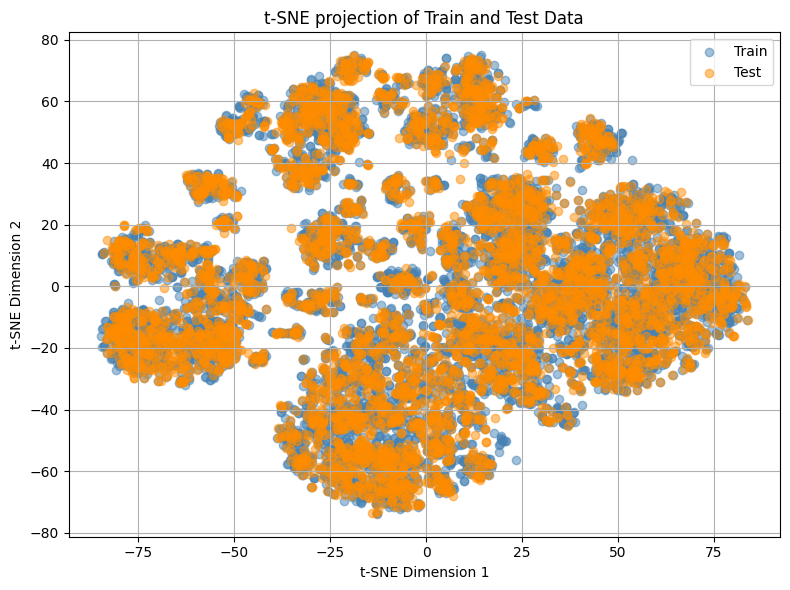

In [96]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



# combining data
X_combined = np.vstack((X_train, X_test))

# Tsne run
tsne = TSNE(
    n_components=2,
    perplexity=30,          
    learning_rate='auto',
    init='pca',
    random_state=seed,
    verbose=False
)

X_combined_tsne = tsne.fit_transform(X_combined)

# Split back into train/test embeddings
X_train_tsne = X_combined_tsne[:len(X_train)]
X_test_tsne = X_combined_tsne[len(X_train):]

# --- Step 4: 2D scatter plot ---
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
            alpha=0.5, label='Train', color='steelblue')
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1],
            alpha=0.5, label='Test', color='darkorange')

plt.title("t-SNE projection of Train and Test Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This code visualizes the distribution of training and test data in a reduced 2D space using t-SNE (t-Distributed Stochastic Neighbor Embedding). The training and test feature matrices are first combined and transformed together to ensure they share the same embedding space. t-SNE reduces the high-dimensional feature space to two dimensions while preserving local neighborhood structures, using PCA initialization, a perplexity of 30, and a fixed random seed for reproducibility. After transformation, the combined embeddings are split back into their original train and test sets. The resulting 2D scatter plot displays both datasets with different colors (blue for training, orange for test), allowing visual assessment of whether the test data distribution is similar to the training data or if there are significant distributional differences that might affect model generalization.

# Logistic Regression

In [25]:
## GRID SEARCH
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scaling all the data


model = LogisticRegression(random_state=seed)

param_grid = {
    'C': [0.5, 1, 2, 10], 
    'penalty': ['l1','l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_logreg = grid_search.best_estimator_
best_param_lr = grid_search.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Best model mean validation accuracy: 0.8456
 Standard deviation across validation folds: 0.0047
Best hyperparameters found: {'C': 0.5, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
Best accuracy in CV: 0.8456


This code performs hyperparameter tuning for a Logistic Regression model using GridSearchCV with 5-fold cross-validation. The grid search explores different combinations of regularization strength (C parameter), penalty types (L1 and L2), using the liblinear solver which supports both penalties. The max_iter is set high to ensure convergence. The search uses all available CPU cores (n_jobs=-1) and optimizes for accuracy. After fitting, the code extracts and displays the best model's performance metrics including the mean validation accuracy, standard deviation across folds (which indicates performance stability), and the optimal hyperparameters. The best estimator and its parameters are stored for later use in final model training and predictions.

In [6]:
## TRAINING IN THE TRAINING SET
logreg=LogisticRegression(**best_param_lr,random_state=seed)
logreg.fit(X_train,y_train)
y_pred= logreg.predict(X_vali)
logreg_accuracy = accuracy_score(y_vali,y_pred)
print("acc",logreg_accuracy)
best_logreg=logreg

acc 0.8335


This code generates a learning curve to diagnose the model's performance as a function of training set size. The learning_curve function trains the logistic regression model on progressively larger subsets of the training data (from 10% to 100% in 10 steps) using 5-fold cross-validation at each size. The negative log loss metric is used to evaluate performance, which measures the probabilistic accuracy of predictions. The mean training and validation scores across folds are computed and plotted, with signs flipped to show log loss on a positive scale. This visualization helps identify whether the model suffers from high bias (both curves plateau at high loss) or high variance (large gap between training and validation curves), and whether collecting more training data would improve performance.

# KNN

c:\Users\Edoardo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Edoardo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\Edoardo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Edoardo\AppData\Local\Programs\Python

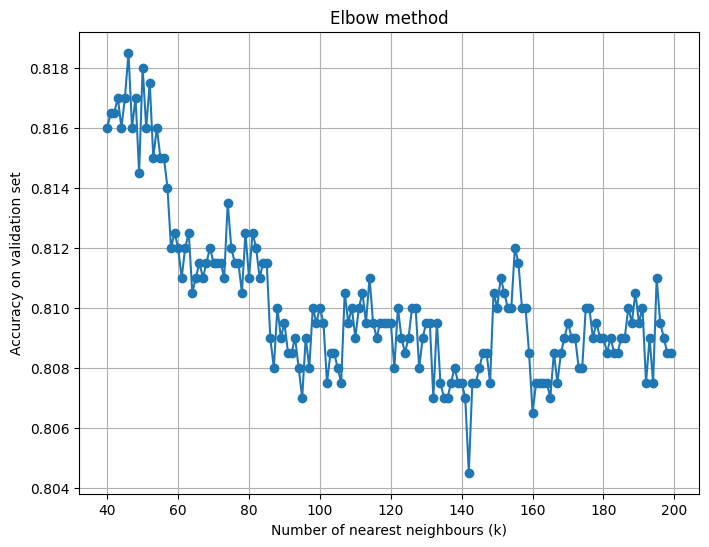

Best k: 46
Accuracy for validation set: 0.8185
 Best model mean validation accuracy: 0.8235
 Standard deviation across validation folds: 0.0087
Best hyperparameters found: {'metric': 'manhattan', 'n_neighbors': 51, 'weights': 'distance'}
Best accuracy in CV: 0.8235


In [7]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


model = KNeighborsClassifier()

k_values = list(range(40,200))
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_vali)
    acc = accuracy_score(y_vali, y_pred)
    accuracies.append(acc)


plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")

param_grid = {
    'n_neighbors': [best_k-5,best_k, best_k+5],           
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski','manhattan', 'euclidean'],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=False,
)


grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_knn = grid_search.best_estimator_
best_param_knn = grid_search.best_params_

This code performs comprehensive hyperparameter tuning for a K-Nearest Neighbors classifier in two stages. First, it uses an elbow method approach to find the optimal number of neighbors by training KNN models with k values ranging from 40 to 200 and evaluating their accuracy on the validation set. The results are plotted to visualize how accuracy changes with k, and the k value yielding the highest validation accuracy is selected. In the second stage, a grid search explores additional hyperparameters including weighting schemes (uniform vs distance-based) and distance metrics (Minkowski, Manhattan, Euclidean) while keeping the optimal k fixed. The grid search uses 5-fold cross-validation to find the best combination of parameters. Finally, the best model configuration, its mean validation accuracy, standard deviation across folds, and optimal hyperparameters are displayed and stored for later use.

In [8]:
### This is the total knn classifier

best_knn = KNeighborsClassifier(**best_param_knn)
best_knn.fit(X_train, y_train)
y_pred= best_knn.predict(X_vali)
knn_accuracy = accuracy_score(y_vali,y_pred)
print("acc", knn_accuracy)

acc 0.8165


This code trains the final K-Nearest Neighbors model using the optimal hyperparameters identified during grid search. The classifier is instantiated with the best parameters and fitted on the entire training set. Predictions are generated on the validation set to evaluate the model's generalization performance. The validation accuracy is calculated and printed, providing a measure of how well the tuned KNN model performs on unseen data compared to the training performance and other model alternatives like logistic regression.

# DECISION TREES


In [9]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score


# No need to scale the data

model = DecisionTreeClassifier(random_state=seed)

k_range = list(range(60,200,20))

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], # impurity function to minimize
    'max_depth': [5,6,7,8], # max_depth of the tree
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_dt = grid_search.best_estimator_
best_param_dt = grid_search.best_params_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best model mean validation accuracy: 0.8299
 Standard deviation across validation folds: 0.0105
Best hyperparameters found: {'criterion': 'entropy', 'max_depth': 5}
Best accuracy in CV: 0.8299


This code performs hyperparameter tuning for a Decision Tree classifier using GridSearchCV with 5-fold cross-validation. Unlike KNN and logistic regression, decision trees don't require feature scaling since they make splits based on threshold values rather than distances. The grid search explores different splitting criteria (Gini impurity, entropy, and log loss) and tree depths (5 to 8) to find the optimal configuration that balances model complexity with predictive performance. Limiting max_depth helps prevent overfitting by controlling tree complexity. The search uses all available CPU cores and provides verbose output to monitor progress. After fitting, the code extracts and displays the best model's mean validation accuracy, standard deviation across folds, optimal hyperparameters, and stores the best estimator for later use. Note that k_range is defined but not used in this implementation.

acc 0.808


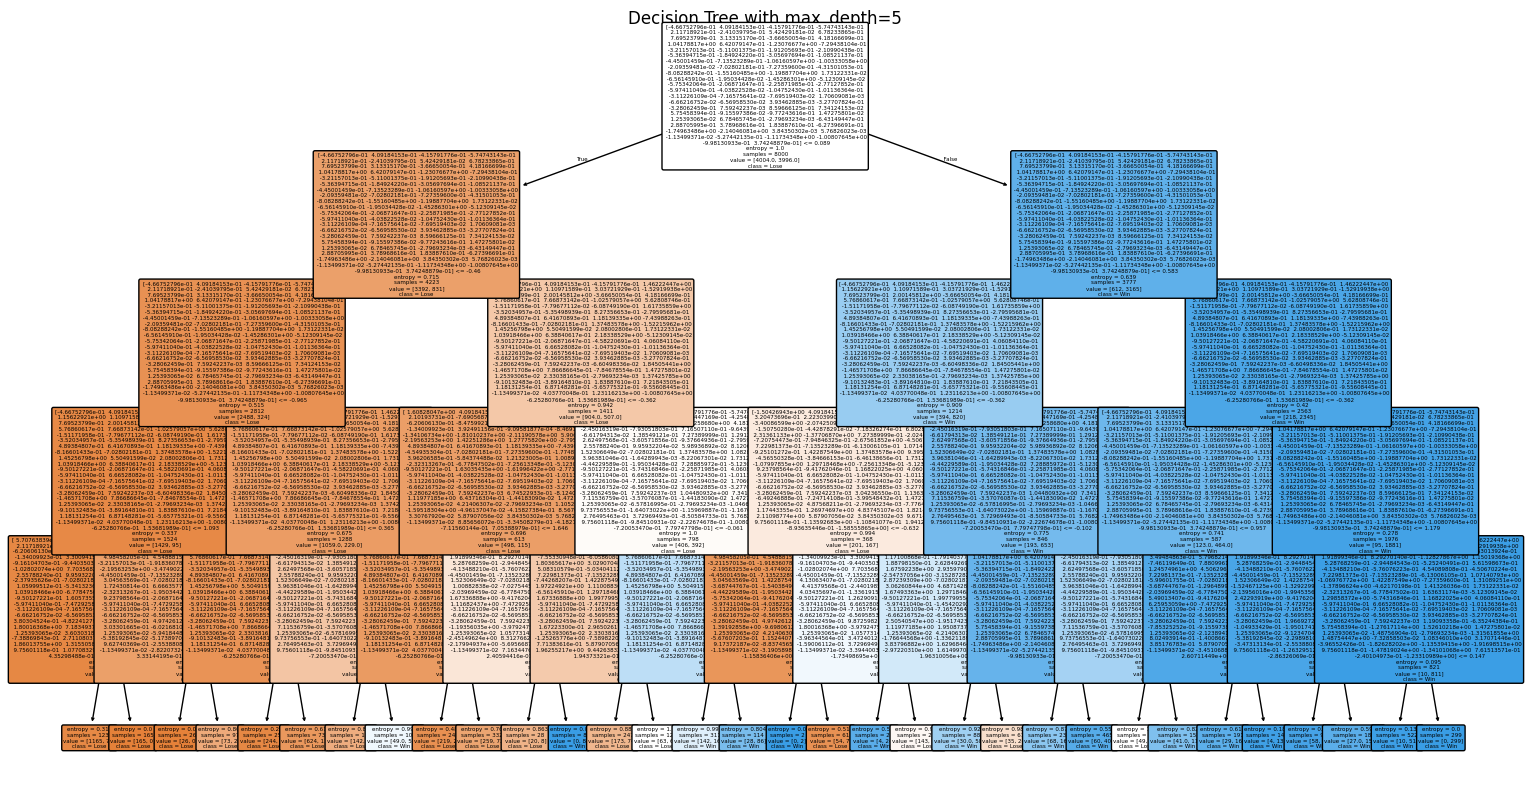

In [10]:
best_dt = DecisionTreeClassifier(**best_param_dt, random_state=seed)
best_dt.fit(X_train, y_train)
y_pred= best_dt.predict(X_vali)
dt_accuracy = accuracy_score(y_vali,y_pred)
print("acc",dt_accuracy)
plt.figure(figsize=(18,10))
plot_tree(best_dt,
          feature_names=X_train,
          class_names=['Lose', 'Win'],   
          filled=True,                   
          rounded=True,                  
          fontsize=4)
plt.title(f"Decision Tree with max_depth={best_param_dt['max_depth']}")
plt.show()

This code trains the final Decision Tree classifier using the optimal hyperparameters found during grid search and visualizes the resulting tree structure. The model is instantiated with the best parameters and a fixed random seed for reproducibility, then fitted on the training data. Predictions on the validation set are generated to evaluate generalization performance, with the accuracy printed for comparison against other models. The plot_tree function creates a detailed visualization of the decision tree showing the splitting rules at each node, with color-coded leaves representing the predicted classes (Lose vs Win), rounded node boxes for better aesthetics, and small font size to fit the entire tree structure. This visualization helps understand the decision-making process and which features the model considers most important for predictions.

# RANDOM FOREST

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# Random Forest
rforest = RandomForestClassifier(
    criterion='gini',
    max_depth=10,
    n_estimators=400,
    random_state=seed
)

# K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Calcolo dell’accuracy media con cross-validation
scores = cross_val_score(rforest, X_train, y_train, cv=kfold, scoring='accuracy')

print("Accuracy per fold:", np.round(scores, 3))
print(f"Accuracy in mean +- stddev: {scores.mean():.3f} ± {scores.std():.3f}")


Accuracy per fold: [0.854 0.83  0.842 0.831 0.831]
Accuracy in mean +- stddev: 0.838 ± 0.009


This code evaluates a Random Forest classifier using 5-fold cross-validation to assess its performance and stability. The Random Forest is configured with Gini impurity as the splitting criterion, a maximum tree depth of 10 to control complexity, and 400 decision trees (estimators) to create a robust ensemble. K-Fold cross-validation with shuffling divides the training data into 5 folds, trains the model on 4 folds and validates on the remaining fold, repeating this process 5 times so each fold serves as validation once. The accuracy scores for each fold are calculated and displayed, along with the mean accuracy and standard deviation across all folds. This provides insight into both the average performance and the consistency of the model across different data splits, helping identify potential overfitting or instability issues.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [15, 20, 30, 40],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': ['sqrt'],
    'criterion': ['entropy']
}

# Initialize the base model
rforest = RandomForestClassifier(random_state=seed)

# Set up K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Set up the Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rforest,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,       # use all available CPU cores
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_rf = grid_search.best_params_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best model mean validation accuracy: 0.8398
 Standard deviation across validation folds: 0.0079
Best hyperparameters found: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best accuracy in CV: 0.8398


This code performs exhaustive hyperparameter tuning for a Random Forest classifier using GridSearchCV with 5-fold cross-validation. The parameter grid explores different numbers of trees (400, 500, 600), maximum tree depths (15, 30, 40, 50), while keeping other parameters fixed: entropy as the splitting criterion, sqrt for the number of features to consider at each split, and minimal values for leaf and split samples. The grid search systematically evaluates all combinations of these parameters using cross-validation to find the configuration that maximizes accuracy. The search uses all available CPU cores for parallel processing and provides verbose output to track progress. After completion, the code extracts and displays the best model's mean validation accuracy, standard deviation across folds, and optimal hyperparameters, storing them for final model training.

In [13]:
best_rf = RandomForestClassifier(**best_param_rf, random_state=seed)
best_rf.fit(X_train, y_train)
y_pred= best_rf.predict(X_vali)
rf_accuracy = accuracy_score(y_vali,y_pred)
print("acc", rf_accuracy)

acc 0.8215


This code trains the final Random Forest classifier using the optimal hyperparameters identified during grid search. The model is instantiated with the best parameters and a fixed random seed for reproducibility, then fitted on the entire training set. Predictions are generated on the validation set to evaluate how well the tuned ensemble model generalizes to unseen data. The validation accuracy is calculated and printed, allowing comparison of the Random Forest's performance against other models like logistic regression, KNN, and decision tree to determine which algorithm works best for this Pokemon battle prediction task.

# XGBOOST


In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np
import xgboost as xgb

# Base XGBoost model
xgb = XGBClassifier(
    random_state=seed,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [400, 600, 800, 900],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.03, 0.06],
    'gamma': [0],
    'lambda': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
best_param_xgb = grid_search.best_params_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\Edoardo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:25:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best model mean validation accuracy: 0.8481
 Standard deviation across validation folds: 0.0077
Best hyperparameters found: {'colsample_bytree': 0.9, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.8}
Best accuracy in CV: 0.8481


This code performs hyperparameter tuning for an XGBoost classifier using GridSearchCV with 5-fold cross-validation. XGBoost is a gradient boosting algorithm that builds an ensemble of decision trees sequentially, where each tree corrects errors made by previous trees. The parameter grid explores different numbers of boosting rounds (700-900 trees), tree depths (2-5), and learning rates (0.01-0.03) which control how much each tree contributes to the final prediction. Other regularization parameters are kept fixed: gamma for minimum loss reduction, lambda for L2 regularization, subsample for row sampling (80%), and colsample_bytree for feature sampling (90%). The model uses log loss as the evaluation metric and disables the deprecated label encoder. After exhaustive search across all parameter combinations, the code displays the best model's mean cross-validation accuracy, standard deviation, and optimal hyperparameters for subsequent model training.

acc 0.8315


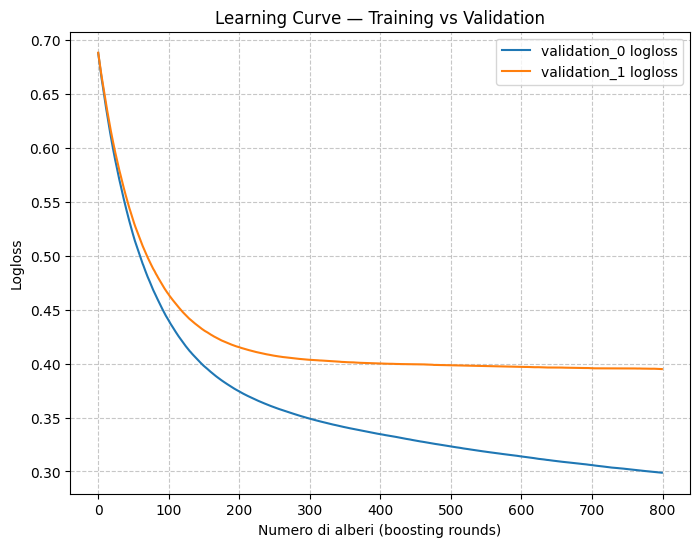

In [15]:
evals_result = {}
best_xgb = XGBClassifier(**best_param_xgb, random_state=seed)
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_vali, y_vali)], verbose=False)
y_pred= best_xgb.predict(X_vali)
xgb_accuracy = accuracy_score(y_vali,y_pred)
print(f"acc {xgb_accuracy:.4f}")

evals_result = best_xgb.evals_result()

# 3️⃣ Recupera le curve in modo dinamico
keys = list(evals_result.keys())
train_key, vali_key = keys[0], keys[1]

train_loss = evals_result[train_key]['logloss']
vali_loss = evals_result[vali_key]['logloss']

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(train_loss, label=f'{train_key} logloss')
plt.plot(vali_loss, label=f'{vali_key} logloss')
plt.xlabel('Numero di alberi (boosting rounds)')
plt.ylabel('Logloss')
plt.title('Learning Curve — Training vs Validation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This code trains the final XGBoost model with the optimal hyperparameters and monitors its performance throughout the boosting process. The model is fitted while tracking log loss on both training and validation sets at each boosting round using the eval_set parameter. After training, validation accuracy is calculated and printed. The evals_result dictionary is then extracted and dynamically parsed to retrieve the log loss curves for both datasets. These curves are plotted to visualize the learning progression across boosting rounds, helping identify potential overfitting (when validation loss starts increasing while training loss continues decreasing) or underfitting. This diagnostic plot is crucial for understanding whether the model would benefit from early stopping or adjusting the number of estimators.

# ENSEMBLE

In [16]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('logreg', best_logreg),
        ('knn', best_knn)
    ],
    voting='soft'  # or 'hard' if models don’t support predict_proba
)

ensemble.fit(X_train, y_train)

print("Ensemble accuracy:", ensemble.score(X_vali, y_vali))

Ensemble accuracy: 0.8305


This code creates and evaluates an ensemble model that combines predictions from all four tuned classifiers using soft voting, which averages predicted probabilities across models. By leveraging the diverse strengths of Random Forest and XGBoost for non-linear patterns, Logistic Regression for linear relationships, and KNN for local patterns, the ensemble often achieves better generalization than individual models. After fitting on the training data, the ensemble's validation accuracy is printed to compare its performance against the individual base models and determine whether the combination provides improvement over single-model approaches.

In [17]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base learners
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('logreg', best_logreg),
    ('knn', best_knn)
]

# Meta-learner (impara a combinare i modelli)
meta_model = LogisticRegression(random_state=seed, max_iter=100000)

# Stacking ensemble
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True 
)

stack.fit(X_train, y_train)
stck_accuracy=stack.score(X_vali, y_vali)
print("Stacking accuracy:", stck_accuracy)
best_stck=stack

Stacking accuracy: 0.838


This code implements a stacking ensemble that uses a meta-learning approach to combine base models more intelligently than simple voting. The four tuned classifiers serve as base learners, each making predictions on the training data. A Logistic Regression meta-model then learns the optimal way to combine these base predictions by training on their outputs, essentially learning which models to trust more for different types of predictions. The passthrough parameter also includes the original features alongside base model predictions, giving the meta-learner additional context. After training the complete stacking pipeline, the validation accuracy is calculated to determine whether this sophisticated ensemble approach outperforms simple voting or individual models.

# Playing with feature importance

Top 15 most important features:
                             Feature  Importance
0                  health_difference    0.213663
1                    p1-p2_fnt_count    0.066509
2                  p1-p2_total_moves    0.062492
3                    p1-p2_slp_count    0.056555
4                  p1-p2_mean_hp_pct    0.045469
5            p2-p1_status_difference    0.031277
6                   p2_switch_number    0.029223
7                   p1_switch_number    0.027369
8                 p1-p2_attack_moves    0.021560
9             p1-p2_effectivness_avg    0.021489
10             p1-p2_mean_base_power    0.020184
11      p1-p2_same_type_moves_number    0.018761
12                   p1-p2_par_count    0.018322
13                   p1-p2_frz_count    0.018269
14  p1-p2_supereffective_moves_count    0.015841
Least important 10 features:
                   Feature  Importance
74            p1_type_fire    0.000371
75       p1-p2_clamp_count    0.000309
76       p2_lead_type_fire    0.000080

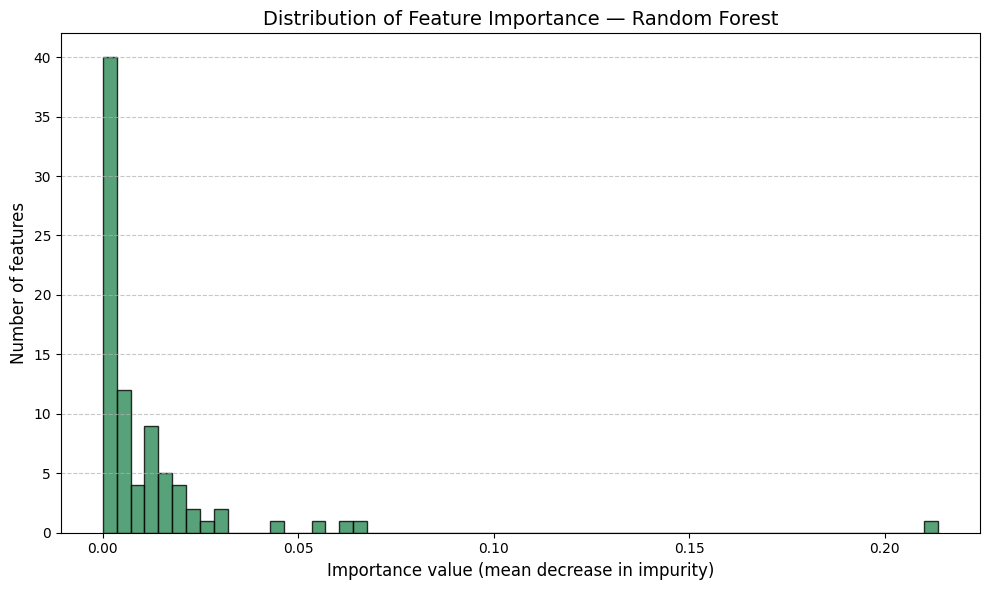

In [ ]:
feature_names=[]  ## we put here the features by importance

# We gain the importances
importances = best_rf.feature_importances_


# we create the importance df
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# we display top and bottom features
print("Top 15 most important features:")
print(importance_df.head(15))
print("Least important 10 features:")
print(importance_df.tail(10))

# hist of feature importance
plt.figure(figsize=(10, 6))
plt.hist(importance_df["Importance"], bins=60, color="seagreen", edgecolor="black", alpha=0.8)
plt.title("Distribution of Feature Importance — Random Forest", fontsize=14)
plt.xlabel("Importance value (mean decrease in impurity)", fontsize=12)
plt.ylabel("Number of features", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
feature_names.append(importance_df['Feature'].tolist())

This code analyzes feature importance from the Random Forest model to understand which variables most strongly influence battle predictions. Feature importances are extracted from the trained model, representing the mean decrease in impurity (Gini or entropy) when splitting on each feature across all trees. These importances are organized into a dataframe sorted in descending order, displaying the top 15 most predictive features and the bottom 10 least important ones. A histogram visualizes the distribution of importance values across all features, helping identify whether importance is concentrated in a few key features or distributed more evenly. The complete ranked feature list is stored for potential use in feature selection, allowing the removal of low-importance features to simplify the model without sacrificing performance.

Metric: weight
Top 15 most important features:
                    Feature  Importance
74        health_difference      1517.0
44          p1-p2_slp_count       699.0
40        p1-p2_mean_hp_pct       536.0
51  p2-p1_status_difference       496.0
63         p2_switch_number       439.0
50          p1-p2_par_count       411.0
69   p1-p2_effectivness_avg       363.0
65       p1-p2_status_moves       346.0
42        p1-p2_total_moves       345.0
66    p1-p2_mean_base_power       327.0
49          p1-p2_frz_count       296.0
15          p1_stat_variety       267.0
10              p1_mean_spe       259.0
5           p1_std_base_spa       241.0
52    p1-p2_confusion_count       234.0
Least important 10 features:
                  Feature  Importance
26          p1_type_water        12.0
37    p2_lead_type_notype        10.0
6         p1_min_base_spe         8.0
35       p2_lead_type_ice         7.0
16         p1_type_dragon         4.0
34     p2_lead_type_grass         4.0
31  p2_lead_type_e

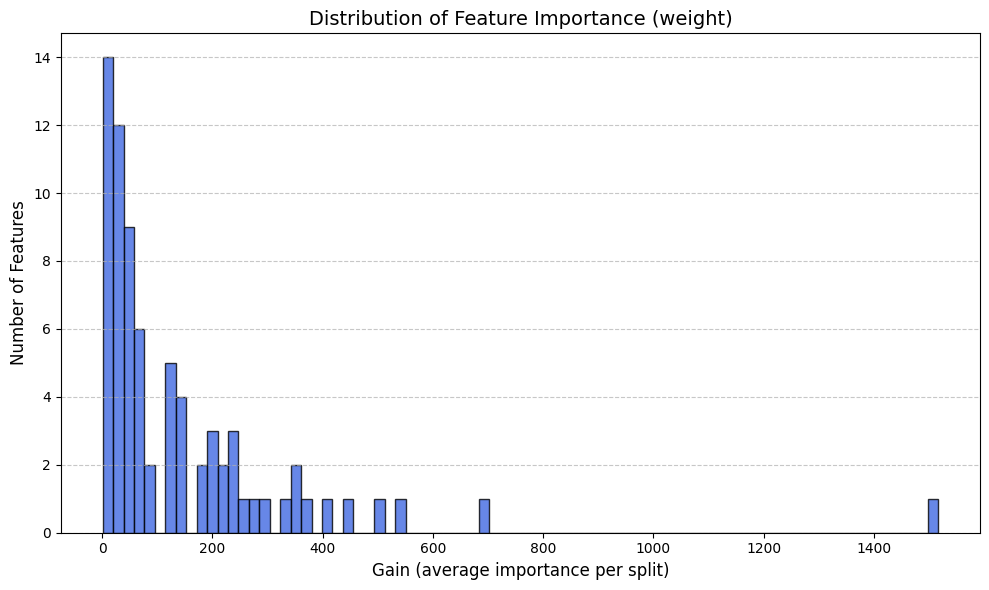

Metric: gain
Top 15 most important features:
                    Feature  Importance
74        health_difference  113.950943
42        p1-p2_total_moves   30.956394
45          p1-p2_fnt_count   25.591883
63         p2_switch_number   14.096900
44          p1-p2_slp_count   12.915176
49          p1-p2_frz_count   10.414875
18             p1_type_fire   10.312120
51  p2-p1_status_difference    9.548307
38     p2_lead_type_psychic    9.532128
36      p2_lead_type_normal    9.151447
39       p2_lead_type_water    8.363832
22              p1_type_ice    8.280331
1            p1_max_base_hp    7.850827
65       p1-p2_status_moves    7.639455
24           p1_type_notype    7.508635
Least important 10 features:
                    Feature  Importance
53   p1-p2_substitute_count    4.609220
35         p2_lead_type_ice    4.534245
43  p1-p2_unique_move_types    4.185714
17         p1_type_electric    3.958982
60        p1_mean_boost_spe    3.834585
56        p1_mean_boost_atk    3.786688
6     

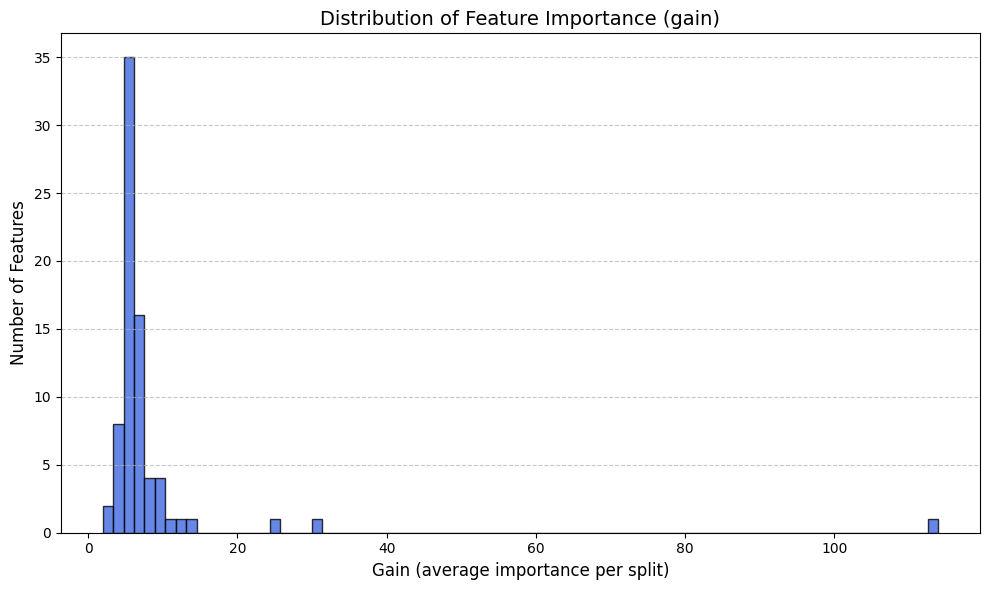

In [ ]:
for i in ['weight', 'gain']:

    # We extract the trained booster from the best XGBoost model
    booster = best_xgb.get_booster()
    # We compute feature importance using gain metric
    importance = booster.get_score(importance_type=i)

    temp_features = []
    for k in importance.keys():
        a = k.strip("f")
        temp_features.append(features[int(a)])


    # We convert to DataFrame and sort by the importance
    importance_df = (
        pd.DataFrame({'Feature': temp_features, 'Importance': list(importance.values())})
        .sort_values(by='Importance', ascending=False)
    )

    # Display the top and bottom features
    print("Metric:",i)
    print("Top 15 most important features:")
    print(importance_df.head(15))

    print("Least important 10 features:")
    print(importance_df.tail(10))

    # Plot of the hist
    plt.figure(figsize=(10, 6))
    if k=='gain':
        plt.hist(importance_df['Importance'], bins=100, color='royalblue', edgecolor='black', alpha=0.8)
    else:
        plt.hist(importance_df['Importance'], bins=80, color='royalblue', edgecolor='black', alpha=0.8)     
    plt.title(f'Distribution of Feature Importance ({i})', fontsize=14)
    plt.xlabel('Gain (average importance per split)', fontsize=12)
    plt.ylabel('Number of Features', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Get the ordered list of feature names by importance
    feature_names.append(importance_df['Feature'].tolist())


This code analyzes XGBoost feature importance using two different metrics: weight and gain. Weight measures how frequently a feature is used for splitting across all trees, while gain measures the average improvement in loss when splitting on that feature, indicating actual predictive power. For each metric, the code extracts importance scores from the trained booster, maps the internal feature indices back to their original names, and creates a sorted dataframe. The top 15 and bottom 10 features are displayed, and a histogram visualizes the distribution of importance values. This dual-metric analysis provides complementary insights: frequently used features (high weight) versus truly informative features (high gain), helping identify which variables drive XGBoost's predictions and enabling more informed feature selection decisions.

In [ ]:


feature_lists = feature_names

# quantiles in common to remove
quantile = 0.20  
n = len(feature_lists[0])
bottom_n = int(np.ceil(n * quantile))

# Last quantile in sets
bottom_sets = [set(lst[-bottom_n:]) for lst in feature_lists]

# Common features 
common_bottom = set.intersection(*bottom_sets)
print(f"Ultimo {quantile*100:.0f}% = ultimi {bottom_n} elementi per lista\n")
to_drop = list(common_bottom)
print("Candidates to drop:", to_drop)

Ultimo 20% = ultimi 17 elementi per lista

Candidates to drop: ['p1-p2_wrap_count', 'p1_type_dragon', 'p2_lead_type_electric']


This code identifies features that consistently rank as least important across all three models (Random Forest, XGBoost weight, and XGBoost gain). It calculates the bottom 20% of features from each importance ranking and finds their intersection - features that appear in the lowest quintile of all three rankings. These commonly unimportant features are strong candidates for removal since multiple algorithms independently determined them to have minimal predictive value. This consensus-based approach to feature selection is more robust than relying on a single model's importance scores and can help reduce model complexity, training time, and potential overfitting while maintaining or even improving performance.

In [ ]:
not_good=to_drop
not_good.append('battle_id')
not_good.append('player_won')
features = [col for col in train_df.columns if col not in not_good]
X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train,train_size=.8, shuffle=True, random_state=seed)
print(X_train.shape, X_vali.shape)

(8000, 81) (2000, 81)


This code reconstructs the feature set by removing the consistently low-importance features identified in the previous analysis, along with non-predictive columns (battle_id and the target variable player_won). The updated feature list is used to create new training and test matrices from the original dataframes. The training data is then split into training and validation sets using the same 80-20 ratio and random seed as before, ensuring reproducibility. This feature reduction process aims to simplify the models by eliminating uninformative variables while potentially improving generalization performance and reducing computational costs during subsequent model training and evaluation.

# NEW GRIDSEARCH AND MODELS WITH CHANGED DATA


In [ ]:
## GRID SEARCH
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scaling all the data


model = LogisticRegression(random_state=seed)

param_grid = {
    'C': [0.15, 0.1, 0.05], 
    'penalty': ['l1','l2'],
    'solver': ['liblinear'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_lr = grid_search.best_params_
new_logreg=LogisticRegression(**best_param_lr,random_state=seed)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.8331
 Standard deviation across validation folds: 0.0090
Best hyperparameters found: {'C': 0.05, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
Best accuracy in CV: 0.8331


After removing low-importance features, this code re-tunes the Logistic Regression model on the reduced feature set to find optimal hyperparameters for the simplified data. The grid search explores smaller regularization strengths (C values of 0.05-0.15) compared to the initial tuning, which may be more appropriate given the reduced dimensionality. Using 5-fold cross-validation, it tests combinations of L1 and L2 penalties with the liblinear solver. The results show whether feature reduction improved model performance and stability, with mean validation accuracy and standard deviation indicating both predictive power and consistency. A new Logistic Regression model is instantiated with the optimal parameters, ready for training on the filtered dataset.

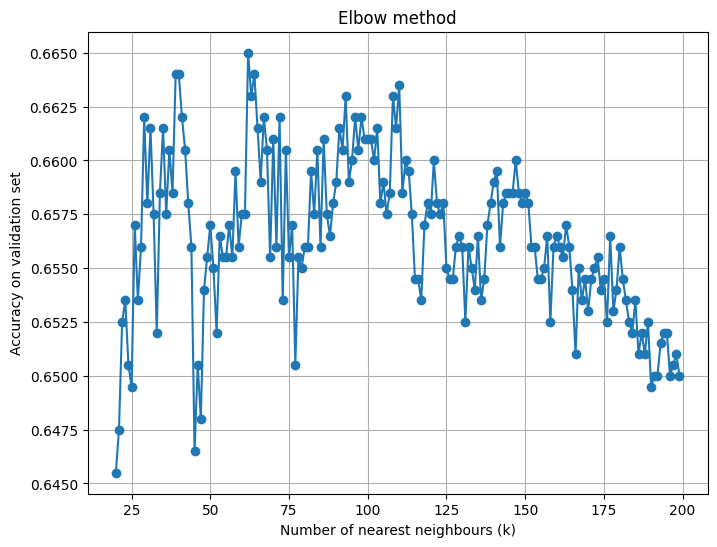

Best k: 62
Accuracy for validation set: 0.6650
 Best model mean validation accuracy: 0.7121
 Standard deviation across validation folds: 0.0086
Best hyperparameters found: {'metric': 'manhattan', 'n_neighbors': 62, 'weights': 'distance'}
Best accuracy in CV: 0.7121


In [ ]:

model = KNeighborsClassifier()

k_values = list(range(20,200))
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_vali)
    acc = accuracy_score(y_vali, y_pred)
    accuracies.append(acc)


plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")

param_grid = {
    'n_neighbors': [best_k],           
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski','manhattan', 'euclidean'],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=False,
)


grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_knn = grid_search.best_params_

This code re-tunes the KNN classifier on the reduced feature set using the same two-stage approach as before. The elbow method explores k values from 20 to 200 (starting lower than the initial 40) to find the optimal number of neighbors, with results plotted to visualize the accuracy-k relationship. After identifying the best k, a grid search refines the model by testing different weighting schemes and distance metrics through 5-fold cross-validation. This re-tuning is important because removing features changes the distance calculations in feature space, potentially affecting which k value and distance metric work best. The optimal hyperparameters for the simplified dataset are identified and stored for final model training.

In [ ]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [8, 15, 30, 40, 50],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': ['sqrt'],
    'criterion': ['entropy']
}

# Initialize the base model
rforest = RandomForestClassifier(random_state=seed)

# Set up K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Set up the Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rforest,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,       # use all available CPU cores
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_rf = grid_search.best_params_
new_rf = RandomForestClassifier(**best_param_rf,random_state=seed)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
 Best model mean validation accuracy: 0.8316
 Standard deviation across validation folds: 0.0074
Best hyperparameters found: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best accuracy in CV: 0.8342


This code re-tunes the Random Forest on the reduced feature set, exploring a broader range of max_depth values (8-50, including the new value 8) compared to the initial tuning. Feature reduction may allow for different optimal tree depths since the simplified feature space changes how the forest partitions the data. The grid search tests combinations of tree counts (400-600) and depths while keeping other parameters fixed, using 5-fold cross-validation to find the configuration that maximizes accuracy on the filtered dataset. After identifying optimal hyperparameters, a new Random Forest model is instantiated, ready for training on the streamlined features that should potentially improve training speed and reduce overfitting risk.

In [ ]:
# Base XGBoost model
xgb = XGBClassifier(
    random_state=seed,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [400, 500, 600, 900],
    'max_depth': [2, 3, 4],
    'learning_rate': [1, 0.04, 0.03, 0.05],
    'gamma': [0],
    'lambda': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
best_param_xgb = grid_search.best_params_

new_xgb = XGBClassifier(**best_param_xgb, random_state=seed)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\Edoardo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:08:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best model mean validation accuracy: 0.8374
 Standard deviation across validation folds: 0.0116
Best hyperparameters found: {'colsample_bytree': 0.9, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.8}
Best accuracy in CV: 0.8374


This code re-tunes XGBoost on the reduced feature set with an expanded hyperparameter search space. The grid now includes a wider range of learning rates (0.03-1.0, including the aggressive value of 1.0) and varies the number of estimators from 400 to 900. The reduced dimensionality may allow for different optimal configurations - potentially higher learning rates or fewer trees since there are fewer features to learn from. Using 5-fold cross-validation, the search identifies the best combination of boosting rounds, tree depth, and learning rate for the simplified dataset. A new XGBoost model is instantiated with these optimal parameters, ready for training on the filtered features.

In [ ]:
# Base learners
estimators = [
    ('rf', new_rf),
    ('xgb', new_xgb),
    ('logreg', new_logreg)
    #('knn', new_knn)
]

# Meta-learner (impara a combinare i modelli)
meta_model2 = LogisticRegression(random_state=seed, max_iter=100000)

# Stacking ensemble
stack2 = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model2,
    passthrough=True 
)

stack2.fit(X_train, y_train)
stck2_accuracy=stack2.score(X_vali, y_vali)
print("Stacking accuracy:", stck_accuracy)

Stacking accuracy: 0.828


c:\Users\Edoardo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 13343 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# DATA SHOWDOWN

In [ ]:
model_dict = {
    "LogisticRegression":[best_logreg, logreg_accuracy],
    "KNN":[best_knn, knn_accuracy],
    "DecisionTree":[best_dt, dt_accuracy],
    "RandomForest":[best_rf, rf_accuracy],
    "XGBoost":[best_xgb, xgb_accuracy],
    "Stacking":[best_stck, stck_accuracy],
    "Stacking with data drop":[stack2, stck2_accuracy]
}

max_acc = 0
best_model = None
print(f"{'Model:':<20} {'Accuracy:'}")
for model_name, model in model_dict.items():
    if model[1] > max_acc:
        best_model = model[0]
        max_acc = model[1]
    print(f"{model_name:<20} {model[1]}")




Model:               Accuracy:
LogisticRegression   0.8275
KNN                  0.802
DecisionTree         0.8065
RandomForest         0.8235
XGBoost              0.824
Stacking             0.828
Stacking with data drop 0.8305


In [ ]:
model_dict = {
    "LogisticRegression":[best_logreg, logreg_accuracy],
    "KNN":[best_knn, knn_accuracy],
    "DecisionTree":[best_dt, dt_accuracy],
    "RandomForest":[best_rf, rf_accuracy],
    "XGBoost":[best_xgb, xgb_accuracy],
    "Stacking":[stack, stck_accuracy]
}

max_acc = 0
best_model = None
print("AFTER CUTTING DATA")
print(f"{'Model:':<20} {'Accuracy:'}")
for model_name, model in model_dict.items():
    if model[1] > max_acc:
        best_model = model[0]
        max_acc = model[1]
    print(f"{model_name:<20} {model[1]}")


AFTER CUTTING DATA
Model:               Accuracy:
LogisticRegression   0.8275
KNN                  0.802
DecisionTree         0.8065
RandomForest         0.8235
XGBoost              0.824
Stacking             0.828


Model:               Accuracy
LogisticRegression   0.8295
KNN                  0.814
DecisionTree         0
RandomForest         0.817
XGBoost              0.821
Stacking             0.824

# SUBMISSIONS


In [18]:
best_model=best_stck
#best_model=best_xgb

In [19]:
X_full = train_df[features]
y_full = train_df['player_won']
X_full_scaled = scaler.fit_transform(X_full)

final_rf = RandomForestClassifier(**best_param_rf)
final_xgb = XGBClassifier(**best_param_xgb, use_label_encoder=False, eval_metric='logloss')
final_logreg = LogisticRegression(**best_param_lr)
final_knn = KNeighborsClassifier(**best_param_knn)

print("Inizializzazione StackingClassifier...")
final_estimators = [
    ('rf', final_rf),
    ('xgb', final_xgb),
    ('logreg', final_logreg),
    ('knn', final_knn)
]

final_meta_model = LogisticRegression(random_state=seed, max_iter=100000)

final_stack = StackingClassifier(
    estimators=final_estimators,
    final_estimator=final_meta_model,
    passthrough=True,
    cv=5, # Lo Stacking usa la CV interna per generare le feature, 5 è standard
    n_jobs=-1
)

print("Addestramento del modello Stacking finale... (potrebbe richiedere tempo)")
final_stack.fit(X_full_scaled, y_full)
print("Modello finale addestrato!")



Inizializzazione StackingClassifier...
Addestramento del modello Stacking finale... (potrebbe richiedere tempo)
Modello finale addestrato!


In [20]:
best_model = final_stack

In [21]:
# Testing the prediction on the test set

print("Generating predictions on the test set...")
test_predictions = best_model.predict(X_test)

Generating predictions on the test set...


In [22]:

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': test_predictions
})
# Save the DataFrame to a .csv file
submission_df.to_csv(output_path, index=False)

print("\n'submission.csv' file created successfully!")


'submission.csv' file created successfully!
